In [2]:
import pymongo as pmg
import pandas as pd
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from matplotlib.lines import TICKLEFT, TICKRIGHT, Line2D
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.dates as mdate
from datetime import time
from KRData.HKData import HKFuture
import talib as tb
import configparser
from kline import Kline
from bt_base import tools

OK


In [3]:
conf_parser = configparser.ConfigParser()
conf_parser.read( 'conf.ini')
mg_host = conf_parser.get('MGDB', 'host')
mg_user = conf_parser.get('MGDB', 'user')
mg_password = conf_parser.get('MGDB', 'password')
hf=HKFuture(pwd=mg_password,host=mg_host,user=mg_user)

In [4]:
from bt_base import BackTesting as bt


class bt_std(bt):
    #测试参数-----------------------------------------------------------------------
    def trade_para(self):
        self.Stop_Diff=60
        self.Stop_Macd_CNT=40
        
    def trade_main(self):
        cont=self.Macd_State in ['red','green']
        
        if cont and self._para['trade_p']['trade_state'] =='ready':
            self.trade_step1()
        if cont and self._para['trade_p']['trade_state']=='trade_step1':
            self.trade_step2()
        elif self._para['trade_p']['trade_state']=='trade_step2':
            self.trade_open()
        if self._para['trade_p']['trade_state']=='open':
            self.trade_stop()
        elif self._para['trade_p']['trade_state']=='trade_stop':
            self.trade_close()
#             self.trade_step1()
            
    def trade_init(self):
        self._para['trade']={}
        self._para['trade_p']={}
        self._para['trade_p']['trade_state']='ready'
        
    def trade_step1(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        macd=self.Macd_End
        state=0
        if macd['ma60_state']=='over' and  self.Macd_State=='green':
            state=1
        elif macd['ma60_state']=='over' and  self.Macd_State=='red':
            state=2
        elif macd['ma60_state']=='under' and  self.Macd_State=='red':
            state=3
        elif macd['ma60_state']=='under' and  self.Macd_State=='green':
            state=4
        cont=macd['ma60_state']=='over'
        cont1=cont and self.Macd_State=='green' and macd['std_up']-macd['std_dn']<100
        cont2=cont and self.Macd_State=='red' and macd['std_up']-macd['std_dn']>-100
        cont3=macd['ma60_state']=='under'
        cont4=cont3 and self.Macd_State=='green' and macd['std_up']-macd['std_dn']<100
        if state in [2,4]:
            trade_p['trade_state']='trade_step1'
            trade['type']=state
            trade['macd_day_no']=macd['day_no']
            trade['macd_end_no']=macd['end_no']
            trade['std_up']=macd['std_up']
            trade['std_dn']=macd['std_dn']
            trade['std_diff']=macd['std_up']-macd['std_dn']
            trade['macd_state']=self.Macd_State
        
        self._para['trade']=trade
        self._para['trade_p']=trade_p
        
    def trade_step2(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        macd=self._para['macd']
        row=self._para['row']
        cont=macd['day_no']==trade['macd_day_no']+1
        if cont:
            trade['state']='buy' if trade['macd_state']=='red' else 'sell'
            trade['macd_day_no']=macd['day_no']
            trade['macd_no']=macd['no']
            trade['ma60_no']=macd['ma60_no']
            trade['date']=self._para['date']
            trade['open1']=row['close']
            trade_p['trade_state']='trade_step2'

        self._para['trade']=trade
        self._para['trade_p']=trade_p
        
    def trade_open(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        macd=self._para['macd']
        row=self._para['row']

        trade['open']=row['open']
        trade['open_idx']=self._para['day_no']
        trade['stop_price']=row['open']-self.Stop_Diff if trade['state']=='buy' \
                            else row['open']+self.Stop_Diff
        trade_p['trade_state']='open'

        self._para['trade']=trade
        self._para['trade_p']=trade_p
    
    def trade_stop(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        ma60=self._para['ma60']
        macd=self._para['macd']
        row=self._para['row']
            
        cont1=row['close']<trade['stop_price'] and trade['state']=='buy'
        cont2=row['close']>trade['stop_price'] and trade['state']=='sell'
        cont3=macd['day_no']==trade['macd_day_no']+1
        cont4=macd['cnt']>self.Stop_Macd_CNT
        if any([cont3]):
            trade['close_type']='std'if cont3 else 'stop'
            trade['close1']=row['close']
            trade_p['trade_state']='trade_stop'
        
    def trade_close(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        ma60=self._para['ma60']
        macd=self._para['macd']
        row=self._para['row']

        trade['close']=row['open']
        trade['close_idx']=self._para['day_no']
        trade['diff']=trade['close']-trade['open'] if trade['state']=='buy' \
                    else trade['open'] -trade['close']
        trade['prod']=self._para['prod']
        self._res['trade'].append(trade)
        trade_p['trade_state']='ready'
        self._para['trade']={}
            
    #每日交易结束----------------------------------------------------------------------------------
    def trade_end(self):
        if self._para['trade_p']['trade_state'] !='open':
            return
        trade=self._para['trade']
        row=self._para['row']
        if self._para['trade_p']['trade_state']=='open':
            trade['close']=row['open']
            trade['close1']=row['open']
            trade['close_type']='end'
            trade['close_idx']=self._para['day_no']
            
        trade['diff']=trade['close']-trade['open'] if trade['state']=='buy' \
                                            else trade['open']-trade['close']
        trade['prod']=self._para['prod']
        self._res['trade'].append(trade)
        
print("--OK--")

--OK--


In [6]:
#测试计算
time1=dt.datetime.now()
print(time1)
test=bt_std(hf)
test.Stop_Diff=200
test.Stop_Macd_CNT=60
test.contract_all()
# test.prod_test('HSI1109')
time2=dt.datetime.now()
print(time2-time1)
trade=pd.DataFrame(test._res['trade'])
tools.GetROI(trade)

2019-06-30 14:00:02.182557
0:02:48.418465


{'ALL_Profit': -4161.0,
 'All_CNT': 12177.0,
 'All_Mean': -0.34170978073417096,
 'Win_Sum': 172887.0,
 'Win_CNT': 8354.0,
 'Win_Mean': 20.695116112042136,
 'Win_Max': 206.0,
 'Win_Min': 1.0,
 'Lose_Sum': -177048.0,
 'Lose_CNT': 3651.0,
 'Lose_Mean': -48.49301561216105,
 'Lose_Max': -1.0,
 'Lose_Min': -782.0,
 'Win/Lose': 0.4267648825463481,
 'Win%': 68.60474665352714,
 'ROI': -2.35021011251186}

In [ ]:
cont

In [127]:

print('std_dn_over_green&under_red')
# trade1.to_pickle('pkl/trade_std2.pkl')
trade_a.groupby(['type','std_diff'])['diff'].agg(Calc)
# trade.groupby(['type','std_dn'])['diff'].agg(Calc)


std_dn_over_green&under_red


count     sum        mean     max    min
type std_diff                                          
2    -8            1   -22.0  -22.000000   -22.0  -22.0
     -7            5  -180.0  -36.000000    19.0 -108.0
     -6            3   -55.0  -18.333333    10.0  -64.0
     -5           19  -129.0   -6.789474   216.0 -460.0
     -4           45  -671.0  -14.911111   164.0 -173.0
     -3          120    32.0    0.266667   417.0 -473.0
     -2          307    15.0    0.048860   457.0 -484.0
     -1          760   -27.0   -0.035526   369.0 -413.0
      0         1510  1376.0    0.911258   493.0 -570.0
      1          654 -2314.0   -3.538226   405.0 -406.0
      2          347   161.0    0.463977   379.0 -527.0
      3          196 -1131.0   -5.770408   200.0 -826.0
      4          117  1209.0   10.333333   287.0 -212.0
      5           83  -883.0  -10.638554   249.0 -233.0
      6           51   -92.0   -1.803922   182.0 -204.0
      7           31   618.0   19.935484   345.0  -97.0
      8           29   501.0   17.275862   207.0  -81.0
      9           20    55.0    2.750000   117.0 -175.0
      10           5   117.0   23.400000   181.0 -210.0
      11           5    38.0    7.600000    37.0  -26.0
      12           2   -25.0  -12.500000    -1.0  -24.0
      14           1   -39.0  -39.000000   -39.0  -39.0
      15           1   -92.0  -92.000000   -92.0  -92.0
      17           1   -33.0  -33.000000   -33.0  -33.0
4    -17           1    71.0   71.000000    71.0   71.0
     -15           1   107.0  107.000000   107.0  107.0
     -13           3  -180.0  -60.000000    97.0 -188.0
     -12           4   158.0   39.500000   254.0  -64.0
     -11           8    49.0    6.125000    43.0  -25.0
     -10          11   -75.0   -6.818182    39.0  -41.0
     -9           14  -190.0  -13.571429    26.0  -85.0
     -8           22  -151.0   -6.863636   127.0 -177.0
     -7           35   404.0   11.542857   168.0  -84.0
     -6           59  -352.0   -5.966102   310.0 -188.0
     -5           76  -588.0   -7.736842   148.0 -346.0
     -4          123  -343.0   -2.788618   243.0 -277.0
     -3          185   331.0    1.789189   215.0 -264.0
     -2          284  1684.0    5.929577   428.0 -276.0
     -1          664 -2014.0   -3.033133   396.0 -420.0
      0         1532  -167.0   -0.109008   709.0 -373.0
      1          741  1001.0    1.350877   320.0 -369.0
      2          238  -923.0   -3.878151   364.0 -276.0
      3           95    54.0    0.568421   409.0 -314.0
      4           42  1003.0   23.880952  1047.0 -211.0
      5           27   -42.0   -1.555556   348.0 -204.0
      6            5  -276.0  -55.200000    27.0 -270.0
      7            1    66.0   66.000000    66.0   66.0

In [126]:
cont=(trade.type==4) & (trade.std_up>0) & (trade.macd_end_no>1) 
cont1=(trade.type==4) & (trade.std_up>1) & (trade.macd_end_no==0)
print("(trade.type==4) & (trade.std_up>0) ")
tools.GetROI(trade[cont1 | cont])
trade_b.groupby(['type','std_diff'])['diff'].agg(Calc)

(trade.type==4) & (trade.std_up>0) 


count     sum        mean    max    min
type std_diff                                         
1    -16           1   -56.0  -56.000000  -56.0  -56.0
     -12           2    10.0    5.000000   10.0    0.0
     -10           2   -17.0   -8.500000   -3.0  -14.0
     -9            3   468.0  156.000000  462.0  -14.0
     -8            1    12.0   12.000000   12.0   12.0
     -7            4   100.0   25.000000  122.0  -42.0
     -6           13  -193.0  -14.846154   85.0 -253.0
     -5           15   -78.0   -5.200000   27.0  -89.0
     -4           29   -68.0   -2.344828  178.0 -221.0
     -3           56   267.0    4.767857  230.0 -281.0
     -2           73  -908.0  -12.438356  522.0 -610.0
     -1          249  -910.0   -3.654618  608.0 -367.0
      0          973  1685.0    1.731757  546.0 -430.0
      1          293 -1180.0   -4.027304  255.0 -267.0
      2           53   478.0    9.018868  368.0 -345.0
      3            9   -85.0   -9.444444   56.0 -109.0
3    -3            3   -96.0  -32.000000   11.0 -101.0
     -2           49  -645.0  -13.163265  140.0 -209.0
     -1          288 -1510.0   -5.243056  229.0 -484.0
      0          891  -825.0   -0.925926  320.0 -418.0
      1          212 -1211.0   -5.712264  405.0 -687.0
      2           88   262.0    2.977273  174.0 -208.0
      3           46   893.0   19.413043  540.0 -112.0
      4           23  -160.0   -6.956522   99.0  -79.0
      5            9    58.0    6.444444  174.0  -44.0
      6            9    94.0   10.444444  143.0  -44.0
      7            9    -7.0   -0.777778  181.0  -74.0
      8            5    -4.0   -0.800000   35.0  -42.0
      9            1    27.0   27.000000   27.0   27.0
      10           3    14.0    4.666667   35.0  -15.0
      11           1   -85.0  -85.000000  -85.0  -85.0

In [147]:
Calc=['count','sum','mean','max','min']
cont1=(trade1.type==3) &(trade1.std_up<3) 
cont2=(trade1.type==1) &(trade1.std_up<8) &(trade1.std_up>0) 
cont3=(trade1.type==3) &(trade1.std_dn==0) 
cont4=(trade1.type==1) &(trade1.std_dn<8) &(trade1.std_dn>3) 
tools.GetROI(trade1[cont4 ])

{'ALL_Profit': -1941.0,
 'All_CNT': 176.0,
 'All_Mean': -11.028409090909092,
 'Win_Sum': 2355.0,
 'Win_CNT': 118.0,
 'Win_Mean': 19.95762711864407,
 'Win_Max': 109.0,
 'Win_Min': 1.0,
 'Lose_Sum': -4296.0,
 'Lose_CNT': 57.0,
 'Lose_Mean': -75.36842105263158,
 'Lose_Max': -2.0,
 'Lose_Min': -441.0,
 'Win/Lose': 0.2648009184736294,
 'Win%': 67.04545454545455,
 'ROI': -45.181564245810044}

In [107]:
print("std_dn_type2_4")
cont=(trade.type==4) & (trade.std_dn>3) & (trade.std_dn<10)
tools.GetROI(trade[cont])
trade.groupby(['type','macd_end_no','std_dn'])['diff'].agg(Calc)

std_dn_type2_4


count    sum       mean    max    min
type macd_end_no std_dn                                       
2    0           0        1781 -781.0  -0.438518  126.0 -562.0
                 1        1488  888.0   0.596774  169.0 -382.0
                 2         861  -74.0  -0.085947  137.0 -741.0
                 3         494 -287.0  -0.580972  185.0 -369.0
                 4         371 -947.0  -2.552561  115.0 -448.0
                 5         241  289.0   1.199170  123.0 -354.0
                 6         146 -733.0  -5.020548   91.0 -258.0
                 7          94 -445.0  -4.734043  110.0 -445.0
                 8          45 -457.0 -10.155556   59.0 -383.0
                 9          31 -102.0  -3.290323   88.0 -293.0
                 10         10  119.0  11.900000   63.0  -45.0
                 11          6  180.0  30.000000   51.0   10.0
                 12          4   61.0  15.250000   37.0    1.0
                 13          2   47.0  23.500000   33.0   14.0
                 14          1   17.0  17.000000   17.0   17.0
                 15          1   22.0  22.000000   22.0   22.0
     1           0         260 -772.0  -2.969231   49.0 -371.0
                 1         130   81.0   0.623077   64.0 -162.0
                 2          93 -118.0  -1.268817   81.0 -344.0
                 3          50  702.0  14.040000  169.0  -66.0
                 4          49   21.0   0.428571   68.0  -97.0
                 5          23    8.0   0.347826   34.0  -63.0
                 6          12  124.0  10.333333   48.0  -92.0
                 7           9   69.0   7.666667   33.0  -21.0
                 9           2   23.0  11.500000   20.0    3.0
     2           0         103 -997.0  -9.679612   56.0 -518.0
                 1          16   46.0   2.875000   35.0  -98.0
                 2          11   12.0   1.090909   22.0 -120.0
                 3          10 -131.0 -13.100000   39.0  -86.0
                 4           5    6.0   1.200000   21.0  -29.0
...                        ...    ...        ...    ...    ...
4    1           12          4   32.0   8.000000   33.0  -20.0
                 13          5  106.0  21.200000   51.0    0.0
                 14          1   30.0  30.000000   30.0   30.0
                 15          4   98.0  24.500000   28.0   17.0
                 16          1   20.0  20.000000   20.0   20.0
                 17          2   65.0  32.500000   54.0   11.0
                 18          2   62.0  31.000000   47.0   15.0
                 23          1  -32.0 -32.000000  -32.0  -32.0
     2           0          77 -197.0  -2.558442   50.0 -121.0
                 1          18  281.0  15.611111   74.0  -84.0
                 2           8   79.0   9.875000   19.0    3.0
                 3           8   27.0   3.375000   51.0  -51.0
                 4           5  197.0  39.400000  198.0  -11.0
                 5           4   37.0   9.250000   25.0  -18.0
                 6           2    4.0   2.000000    7.0   -3.0
                 7           2   55.0  27.500000   34.0   21.0
                 9           2    4.0   2.000000    9.0   -5.0
                 10          2  -24.0 -12.000000   13.0  -37.0
     3           0           9 -116.0 -12.888889   14.0  -90.0
                 1           3    5.0   1.666667   11.0  -13.0
                 2           3   27.0   9.000000   27.0    0.0
                 4           2   34.0  17.000000   34.0    0.0
                 6           1   14.0  14.000000   14.0   14.0
                 8           1   33.0  33.000000   33.0   33.0
                 9           1   28.0  28.000000   28.0   28.0
                 12          1   18.0  18.000000   18.0   18.0
     4           0           1    7.0   7.000000    7.0    7.0
                 1           1    4.0   4.000000    4.0    4.0
     5           0           1    8.0   8.000000    8.0    8.0
                 5           1    7.0   7.000000    7.0    7.0

[105 rows x 5 columns]

In [138]:
Calc=['count','sum','mean','max','min']
trade[pd.isnull(trade.close1)]['diff'].agg(Calc)
cont1=(trade.type==4) &(trade.std_dn>1) &(trade.std_dn<20)
cont2=(trade.type==4) &(trade.std_up>1) &(trade.std_up<10)
cont3=(trade.type==4) &(trade.std_dn==1) 
cont4=(trade.type==4) &(trade.std_up<2) 
cont5=(trade.type==2) &(trade.std_dn>4) &(trade.std_dn<10)
cont6=(trade.type==2) &(trade.std_up>5) &(trade.std_dn<10)
tools.GetROI(trade[cont5 | cont6])

# trade.groupby(['macd_day_no','macd_end_no','std_diff'])['diff'].agg(Calc).to_excel('macd_end_no3.xls')
# trade.groupby(['macd_end_no'])['diff'].agg(Calc)

{'ALL_Profit': -1376.0,
 'All_CNT': 1008.0,
 'All_Mean': -1.3650793650793651,
 'Win_Sum': 16927.0,
 'Win_CNT': 678.0,
 'Win_Mean': 24.966076696165192,
 'Win_Max': 123.0,
 'Win_Min': 1.0,
 'Lose_Sum': -18303.0,
 'Lose_CNT': 321.0,
 'Lose_Mean': -57.018691588785046,
 'Lose_Max': -1.0,
 'Lose_Min': -445.0,
 'Win/Lose': 0.43785776208649,
 'Win%': 67.26190476190476,
 'ROI': -7.517893241545096}

In [113]:
cont2=(trade.type==4) &(trade.std_up>1) &(trade.std_up<10)
tools.GetROI(trade[cont2])

{'ALL_Profit': 4945.0,
 'All_CNT': 2334.0,
 'All_Mean': 2.118680377035133,
 'Win_Sum': 39355.0,
 'Win_CNT': 1614.0,
 'Win_Mean': 24.38351920693928,
 'Win_Max': 198.0,
 'Win_Min': 1.0,
 'Lose_Sum': -34410.0,
 'Lose_CNT': 688.0,
 'Lose_Mean': -50.01453488372093,
 'Lose_Max': -1.0,
 'Lose_Min': -345.0,
 'Win/Lose': 0.4875286606909104,
 'Win%': 69.15167095115682,
 'ROI': 14.370822435338553}

In [31]:
trade.groupby('macd_day_no')['diff'].agg(Calc)

,count,sum,mean,max,min
macd_day_no,,,,,
1,941,-823.0,-0.874601,141.0,-741.0
2,584,460.0,0.787671,169.0,-1007.0
3,903,-733.0,-0.811739,185.0,-593.0
4,668,2639.0,3.950599,100.0,-189.0
5,873,-893.0,-1.022910,172.0,-562.0
6,704,145.0,0.205966,117.0,-500.0
7,853,-1050.0,-1.230950,79.0,-510.0
8,695,86.0,0.123741,154.0,-406.0
9,763,-664.0,-0.870249,89.0,-904.0


In [50]:
trade1.groupby(['macd_end_no','std_diff'])['diff'].agg(Calc).to_excel('macd_end_no.xls')

NameError: name 'trade' is not defined

In [7]:
Calc=['sum','count','mean','std','max','min']
trade.set_index('date').resample('B')['diff'].agg(Calc)

,sum,count,mean,std,max,min
date,,,,,,
2011-01-05,-102.0,1,-102.000000,NaN,-102.0,-102.0
2011-01-06,-53.0,1,-53.000000,NaN,-53.0,-53.0
2011-01-07,-4.0,2,-2.000000,31.112698,20.0,-24.0
2011-01-10,35.0,3,11.666667,3.214550,14.0,8.0
2011-01-11,25.0,1,25.000000,NaN,25.0,25.0
2011-01-12,-16.0,1,-16.000000,NaN,-16.0,-16.0
2011-01-13,-18.0,1,-18.000000,NaN,-18.0,-18.0
2011-01-14,-12.0,1,-12.000000,NaN,-12.0,-12.0
2011-01-17,13.0,4,3.250000,13.622897,17.0,-15.0


In [36]:
d1['sum'].cumsum().plot()
plt.grid(True)
plt.show()
d1['count'].mean()

SyntaxError: invalid syntax (<ipython-input-36-be6977df117b>, line 1)

In [44]:
#循环测试某个参数
Calc=['sum','count','mean','std','max','min']
time1=dt.datetime.now()
print(time1)
TestAll={}
df={}
for i in range(20,200,10):
    print(i)
    test=bt_std(hf,index='HSI')
    test.Stop_Macd_CNT=i
    test.prod_all()
#     test.prod_test('HSI1903')
    df[i]=pd.DataFrame(test._res['trade'])
    TestAll[i]=GetROI(df[i])
time2=dt.datetime.now()
print(time2-time1)
pd.DataFrame(TestAll).T

2019-06-11 18:45:13.881254
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0:47:30.956065


,ALL_Profit,All_CNT,All_Mean,Lose_CNT,Lose_Max,Lose_Mean,Lose_Min,Lose_Sum,ROI,Win%,Win/Lose,Win_CNT,Win_Max,Win_Mean,Win_Min,Win_Sum
20,6496.0,3820.0,1.700524,1123.0,-1.0,-33.280499,-339.0,-37374.0,17.381067,69.581152,0.495933,2658.0,310.0,16.504891,1.0,43870.0
30,7251.0,3801.0,1.907656,1048.0,-1.0,-35.435115,-391.0,-37136.0,19.525528,71.375954,0.461713,2713.0,310.0,16.360855,1.0,44387.0
40,9402.0,3785.0,2.484016,1028.0,-1.0,-34.038911,-427.0,-34992.0,26.868999,71.730515,0.480373,2715.0,310.0,16.351381,1.0,44394.0
50,10481.0,3775.0,2.776424,1017.0,-1.0,-33.349066,-449.0,-33916.0,30.902819,71.947020,0.490163,2716.0,310.0,16.346465,1.0,44397.0
60,10932.0,3772.0,2.898197,1014.0,-1.0,-33.002959,-409.0,-33465.0,32.666965,72.004242,0.495303,2716.0,310.0,16.346465,1.0,44397.0
70,10711.0,3772.0,2.839608,1014.0,-1.0,-33.220907,-409.0,-33686.0,31.796592,72.004242,0.492054,2716.0,310.0,16.346465,1.0,44397.0
80,10665.0,3772.0,2.827413,1014.0,-1.0,-33.266272,-437.0,-33732.0,31.616862,72.004242,0.491383,2716.0,310.0,16.346465,1.0,44397.0
90,11087.0,3771.0,2.940069,1013.0,-1.0,-32.882527,-432.0,-33310.0,33.284299,72.023336,0.497117,2716.0,310.0,16.346465,1.0,44397.0
100,11086.0,3771.0,2.939804,1013.0,-1.0,-32.883514,-441.0,-33311.0,33.280298,72.023336,0.497102,2716.0,310.0,16.346465,1.0,44397.0
110,11102.0,3771.0,2.944047,1013.0,-1.0,-32.867720,-425.0,-33295.0,33.344346,72.023336,0.497341,2716.0,310.0,16.346465,1.0,44397.0


In [41]:
test.Macd_State
test._para['trade_p']
test.Macd_State 
test.Macd_State in ['red','green']
test._para['trade_p']['trade_state']=='open'

False

In [3]:
from bt_base import GetROI
GetROI(trade)

NameError: name 'trade' is not defined

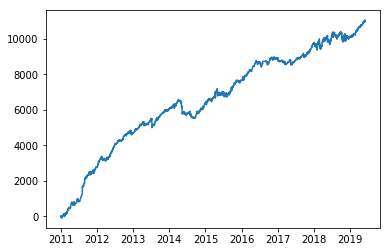

In [29]:
trade.head()
plt.plot(trade.date,trade['diff'].cumsum())

In [72]:
macd.head()

,begin,begin_idx,cnt,date,day_no,diff,end,end_idx,end_no,ma60_no,ma60_state,ma60_state_end,no,prod,state,std_dn,std_dn_list,std_up,std_up_list
0,23143.0,0,36,NaT,0,18.0,23125.0,35,0,0,under,under,0,NaN,green,0,[],0,[]
1,23125.0,35,81,2011-01-03,1,253.0,23378.0,116,0,0,under,over,1,HSI1101,red,0,[],3,"[{'diff': 122.0, 'idx': 59}, {'diff': 41.0, 'i..."
2,23378.0,116,3,2011-01-03,2,-24.0,23402.0,119,1,1,over,over,1,HSI1101,green,0,[],0,[]
3,23402.0,119,28,2011-01-03,3,-12.0,23390.0,147,1,1,over,over,1,HSI1101,red,0,[],0,[]
4,23390.0,147,19,2011-01-03,4,-32.0,23422.0,166,0,1,over,over,2,HSI1101,green,0,[],1,"[{'diff': 16.0, 'idx': 165}]"


In [101]:
macd=pd.read_pickle("pkl/macd.pkl")
cols=['date','no','cnt','diff','std_up','std_dn']
cols1=['date1','no1','cnt1','diff1','std_up1','std_dn1']
cols2=['date2','no2','cnt2','diff2','std_up2','std_dn2']
macd1=macd[cols].copy()
macd1.columns=cols1
macd2=macd[cols].copy()
macd2.columns=cols2
m2=macd.join(macd1.shift(-1))
m2=m2.join(macd2.shift(-2))
m3=m2[(m2.date==m2.date1) & (m2.date==m2.date2)]
m3.head()

,begin,begin_idx,cnt,date,day_no,diff,end,end_idx,end_no,ma60_no,...,cnt1,diff1,std_up1,std_dn1,date2,no2,cnt2,diff2,std_up2,std_dn2
1,23125.0,35,81,2011-01-03,1,253.0,23378.0,116,0,0,...,3.0,-24.0,0.0,0.0,2011-01-03,1.0,28.0,-12.0,0.0,0.0
2,23378.0,116,3,2011-01-03,2,-24.0,23402.0,119,1,1,...,28.0,-12.0,0.0,0.0,2011-01-03,2.0,19.0,-32.0,1.0,0.0
3,23402.0,119,28,2011-01-03,3,-12.0,23390.0,147,1,1,...,19.0,-32.0,1.0,0.0,2011-01-03,1.0,2.0,-45.0,1.0,1.0
4,23390.0,147,19,2011-01-03,4,-32.0,23422.0,166,0,1,...,2.0,-45.0,1.0,1.0,2011-01-03,1.0,16.0,-15.0,1.0,1.0
5,23422.0,166,2,2011-01-03,5,-45.0,23377.0,168,0,3,...,16.0,-15.0,1.0,1.0,2011-01-03,1.0,2.0,-21.0,0.0,0.0


In [75]:
Calc=['sum','count','mean','std','max','min']
m3.groupby(['ma60_state','state',m3.std_up-m3.std_dn])['diff1','diff2'].agg(Calc).to_excel('std_shift_a.xls')

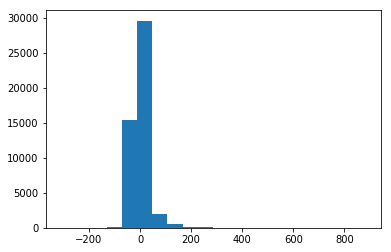

In [8]:
plt.hist(m3.diff1,bins=20)
plt.show()

In [65]:
Calc=['sum','count','mean','std','max','min']
m3.groupby(['ma60_state','state',m3.std_up-m3.std_dn])['diff1'].agg(Calc).to_excel('std_shift1.xls')
# m3.groupby(['ma60_state','state',m3['diff']//50])['diff1'].agg(Calc)

In [9]:
cont2=(m3.ma60_state=='over') & (m3.state=='green') & (m3.std_up-m3.std_dn<-1)
cont3=(m3.ma60_state=='over') & (m3.state=='red') & (m3.std_up-m3.std_dn>1)
cont4=(m3.ma60_state=='under') & ( m3.state=='green') & (m3['std_up']-m3['std_dn']<0)
m4=m3[cont2][['diff1','date']]
m4.columns=['diff','date']
m5=m3[cont4][['diff1','date']]
m5.columns=['diff','date']
tools.GetROI(m5)

{'ALL_Profit': -13350.0,
 'All_CNT': 2588.0,
 'All_Mean': -5.158423493044822,
 'Win_Sum': 27089.0,
 'Win_CNT': 597.0,
 'Win_Mean': 45.37520938023451,
 'Win_Max': 526.0,
 'Win_Min': 1.0,
 'Lose_Sum': -40439.0,
 'Lose_CNT': 1963.0,
 'Lose_Mean': -20.600611309220582,
 'Lose_Max': -1.0,
 'Lose_Min': -255.0,
 'Win/Lose': 2.202614703959058,
 'Win%': 23.068006182380216,
 'ROI': -33.01268577363436}

In [19]:
from bt_base import GetROI
GetROI(m5)

{'ALL_Profit': -11270.0,
 'All_CNT': 3312.0,
 'All_Mean': -3.4027777777777777,
 'Lose_CNT': 2414.0,
 'Lose_Max': -1.0,
 'Lose_Mean': -15.768019884009941,
 'Lose_Min': -310.0,
 'Lose_Sum': -38064.0,
 'ROI': -29.608028583438411,
 'Win%': 25.966183574879228,
 'Win/Lose': 1.9758862674369728,
 'Win_CNT': 860.0,
 'Win_Max': 425.0,
 'Win_Mean': 31.155813953488373,
 'Win_Min': 1.0,
 'Win_Sum': 26794.0}

In [8]:
tools.GetROI(m5[m5['diff'].between(-150,50)])

{'ALL_Profit': -18108.0,
 'All_CNT': 1487.0,
 'All_Mean': -12.177538668459986,
 'Win_Sum': 5729.0,
 'Win_CNT': 302.0,
 'Win_Mean': 18.97019867549669,
 'Win_Max': 50.0,
 'Win_Min': 1.0,
 'Lose_Sum': -23837.0,
 'Lose_CNT': 1178.0,
 'Lose_Mean': -20.23514431239389,
 'Lose_Max': -1.0,
 'Lose_Min': -113.0,
 'Win/Lose': 0.9374876888759114,
 'Win%': 20.3093476798924,
 'ROI': -75.9659353106515}

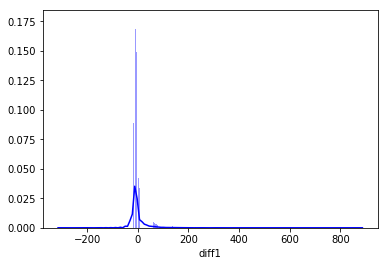

In [13]:
import seaborn as sns

sns.distplot(m3.diff1, hist=True, kde=True,bins=5000,color='b')
# sns.distplot(m3.diff2, hist=True, kde=True)
plt.show()

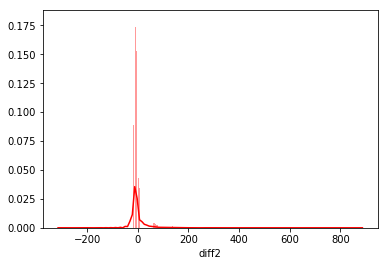

In [12]:
sns.distplot(m3.diff2, hist=True, kde=True,bins=5000,color='r')
plt.show()

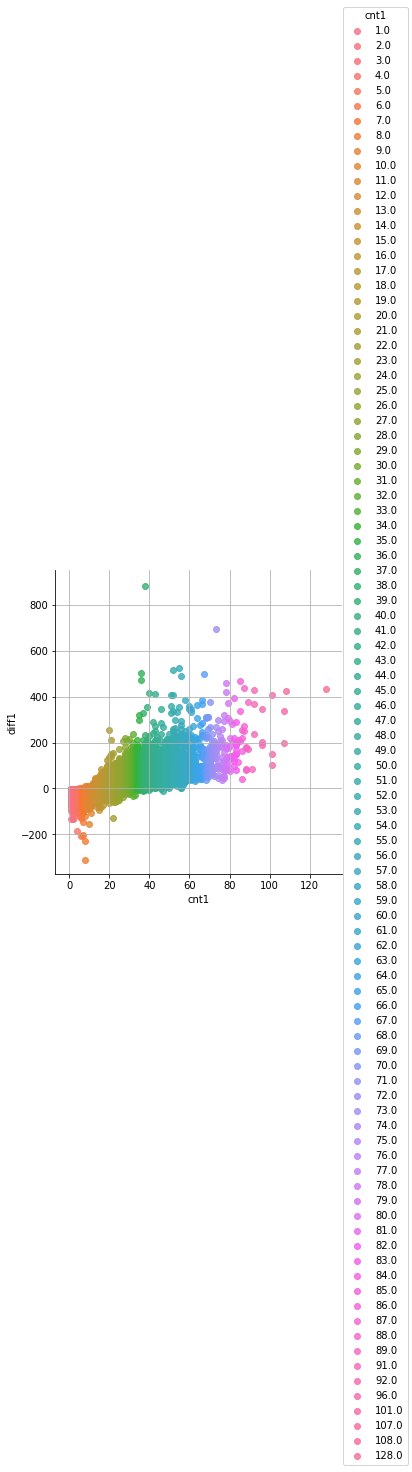

In [29]:
sns.lmplot('cnt1','diff1',m3, hue='cnt1',fit_reg=False)
plt.grid(True)
# m3.head()
plt.show()

In [62]:
def drawKK(k,prod,date,**para):
    t1=dt.time(9,15,0)
    t2=dt.time(16,30,0)
    # a2=aa[aa.datetime.apply(lambda x:t1<=x.time()<=t2)]
    rec_end=66
    test1=bt(hf)
    # prod='HSI1103'
    test1.prod_init(prod)
    aa=test1._para['df_prod']
    a2=aa[aa.datetime.apply(lambda x:t1<=x.time()<=t2)]
    # date='2011-02-28'
    k.DrawKline(a2[a2.trade_date==date],rec=(7,66),**para)

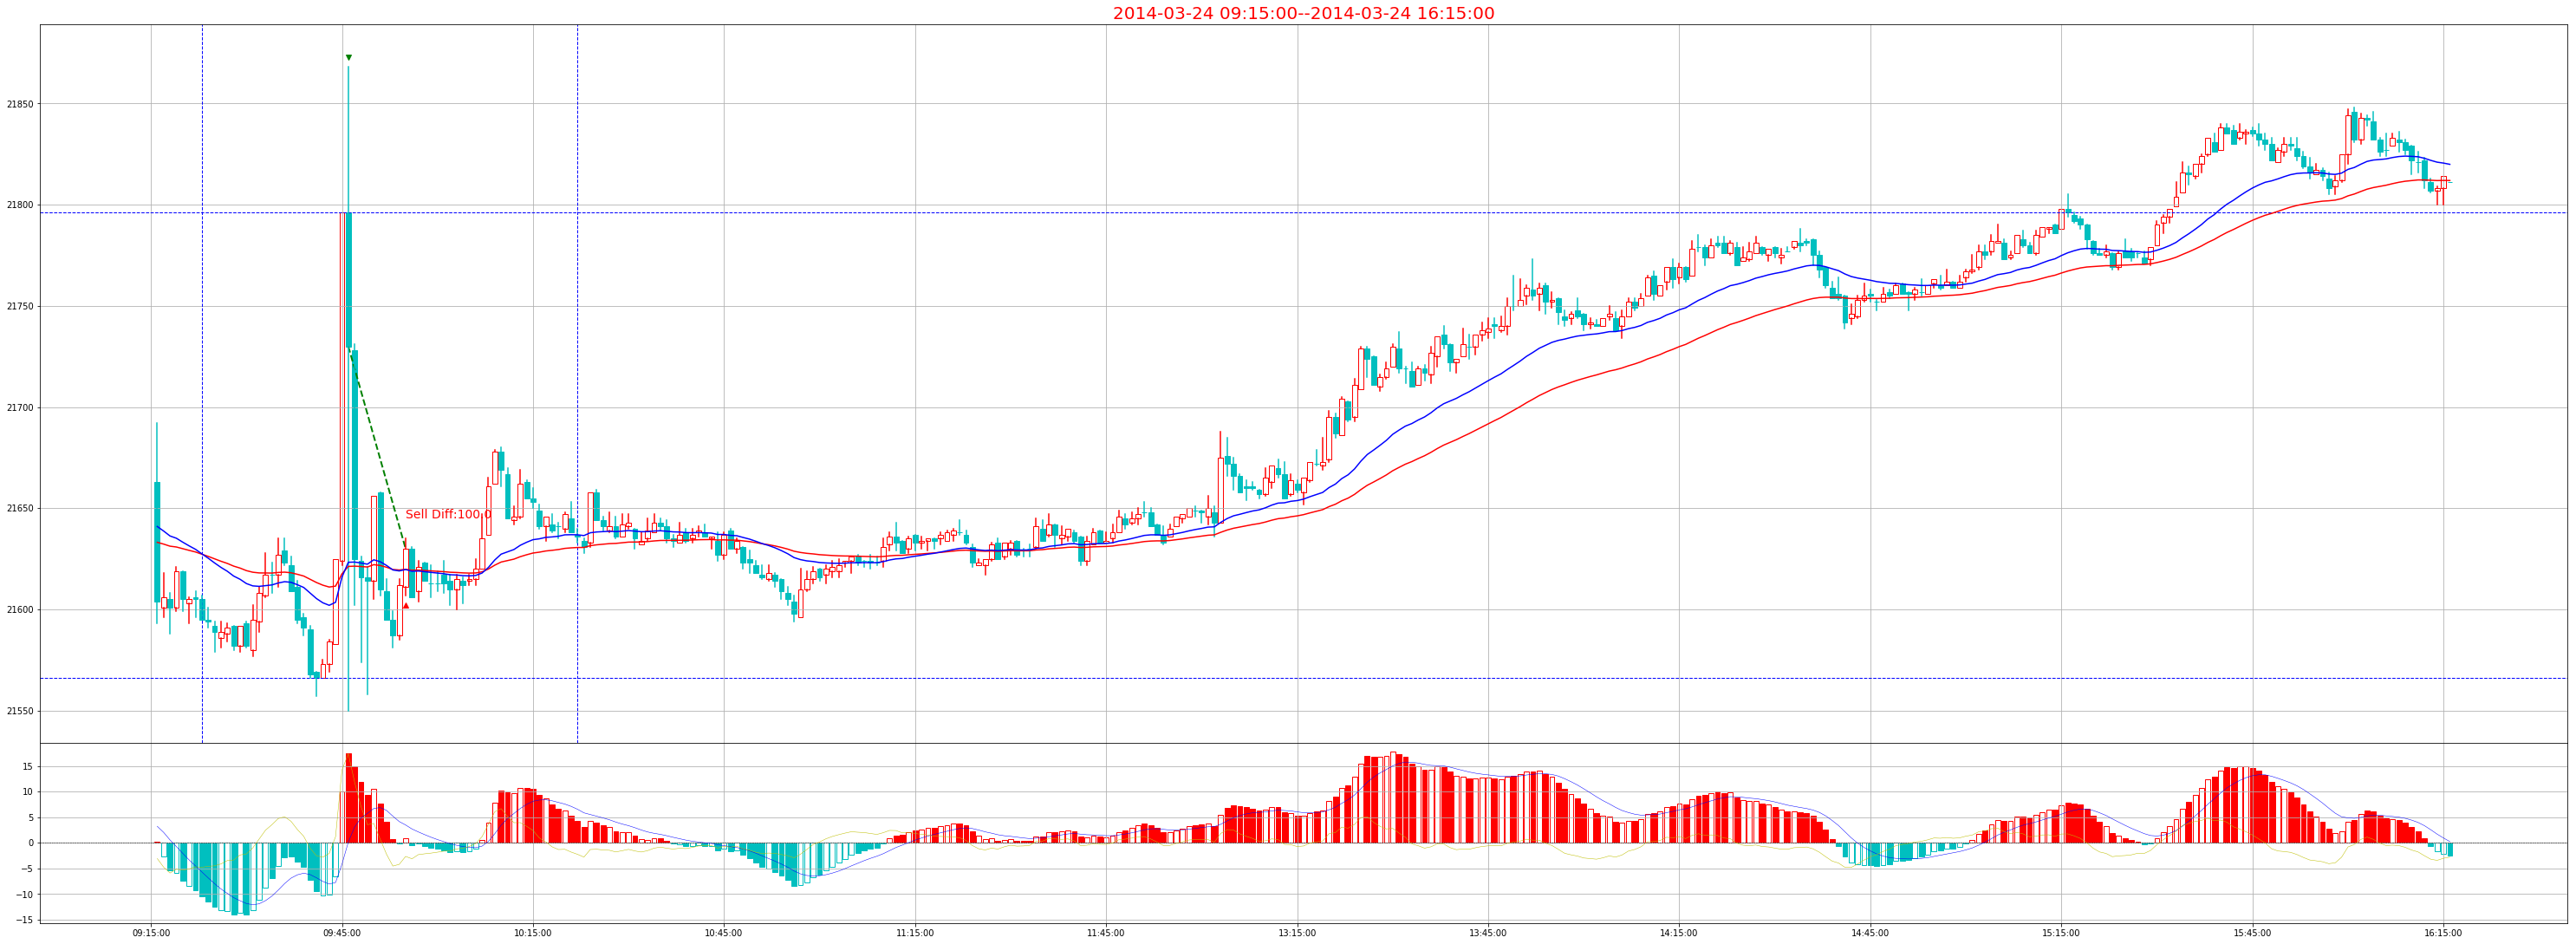

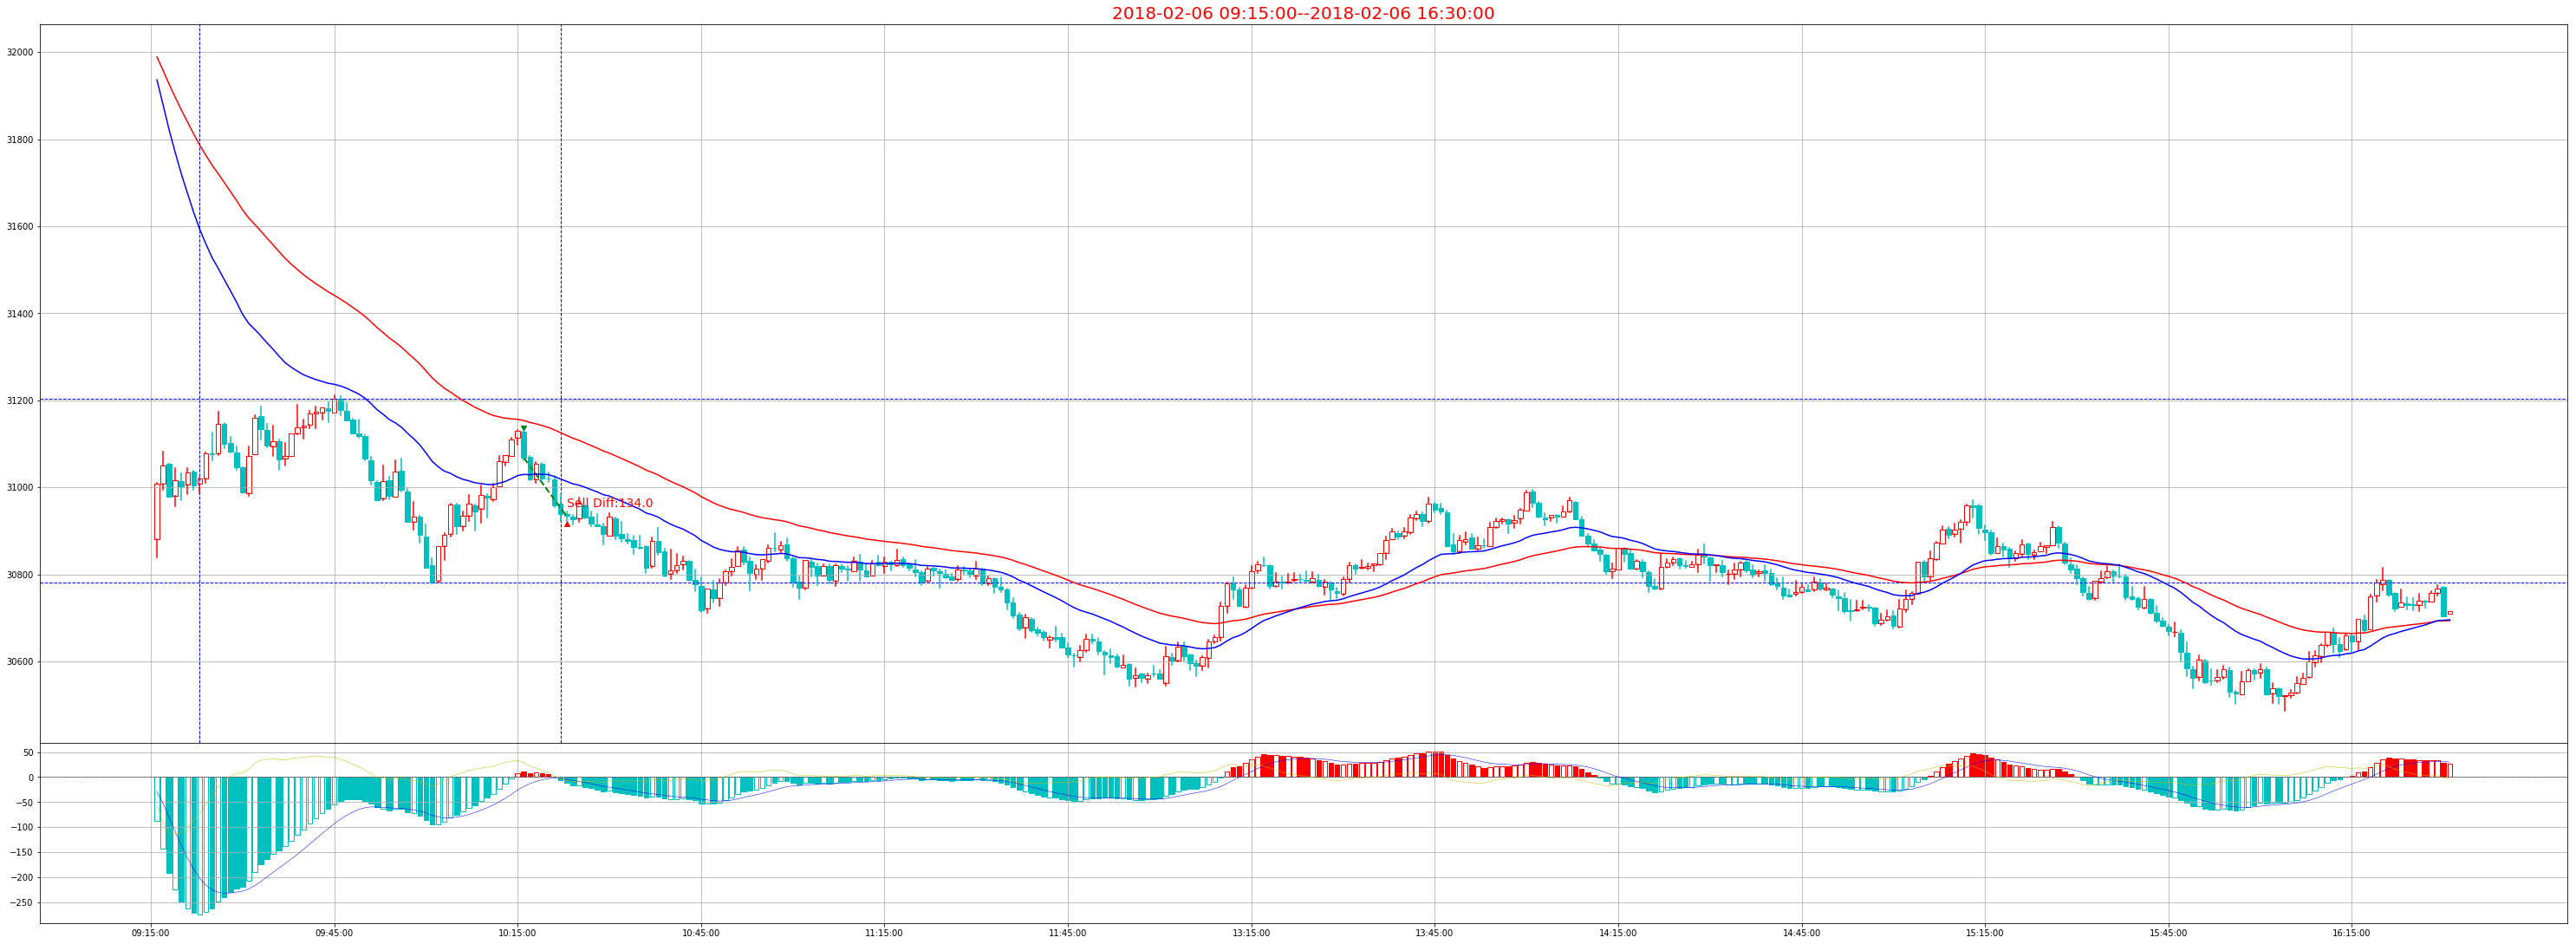

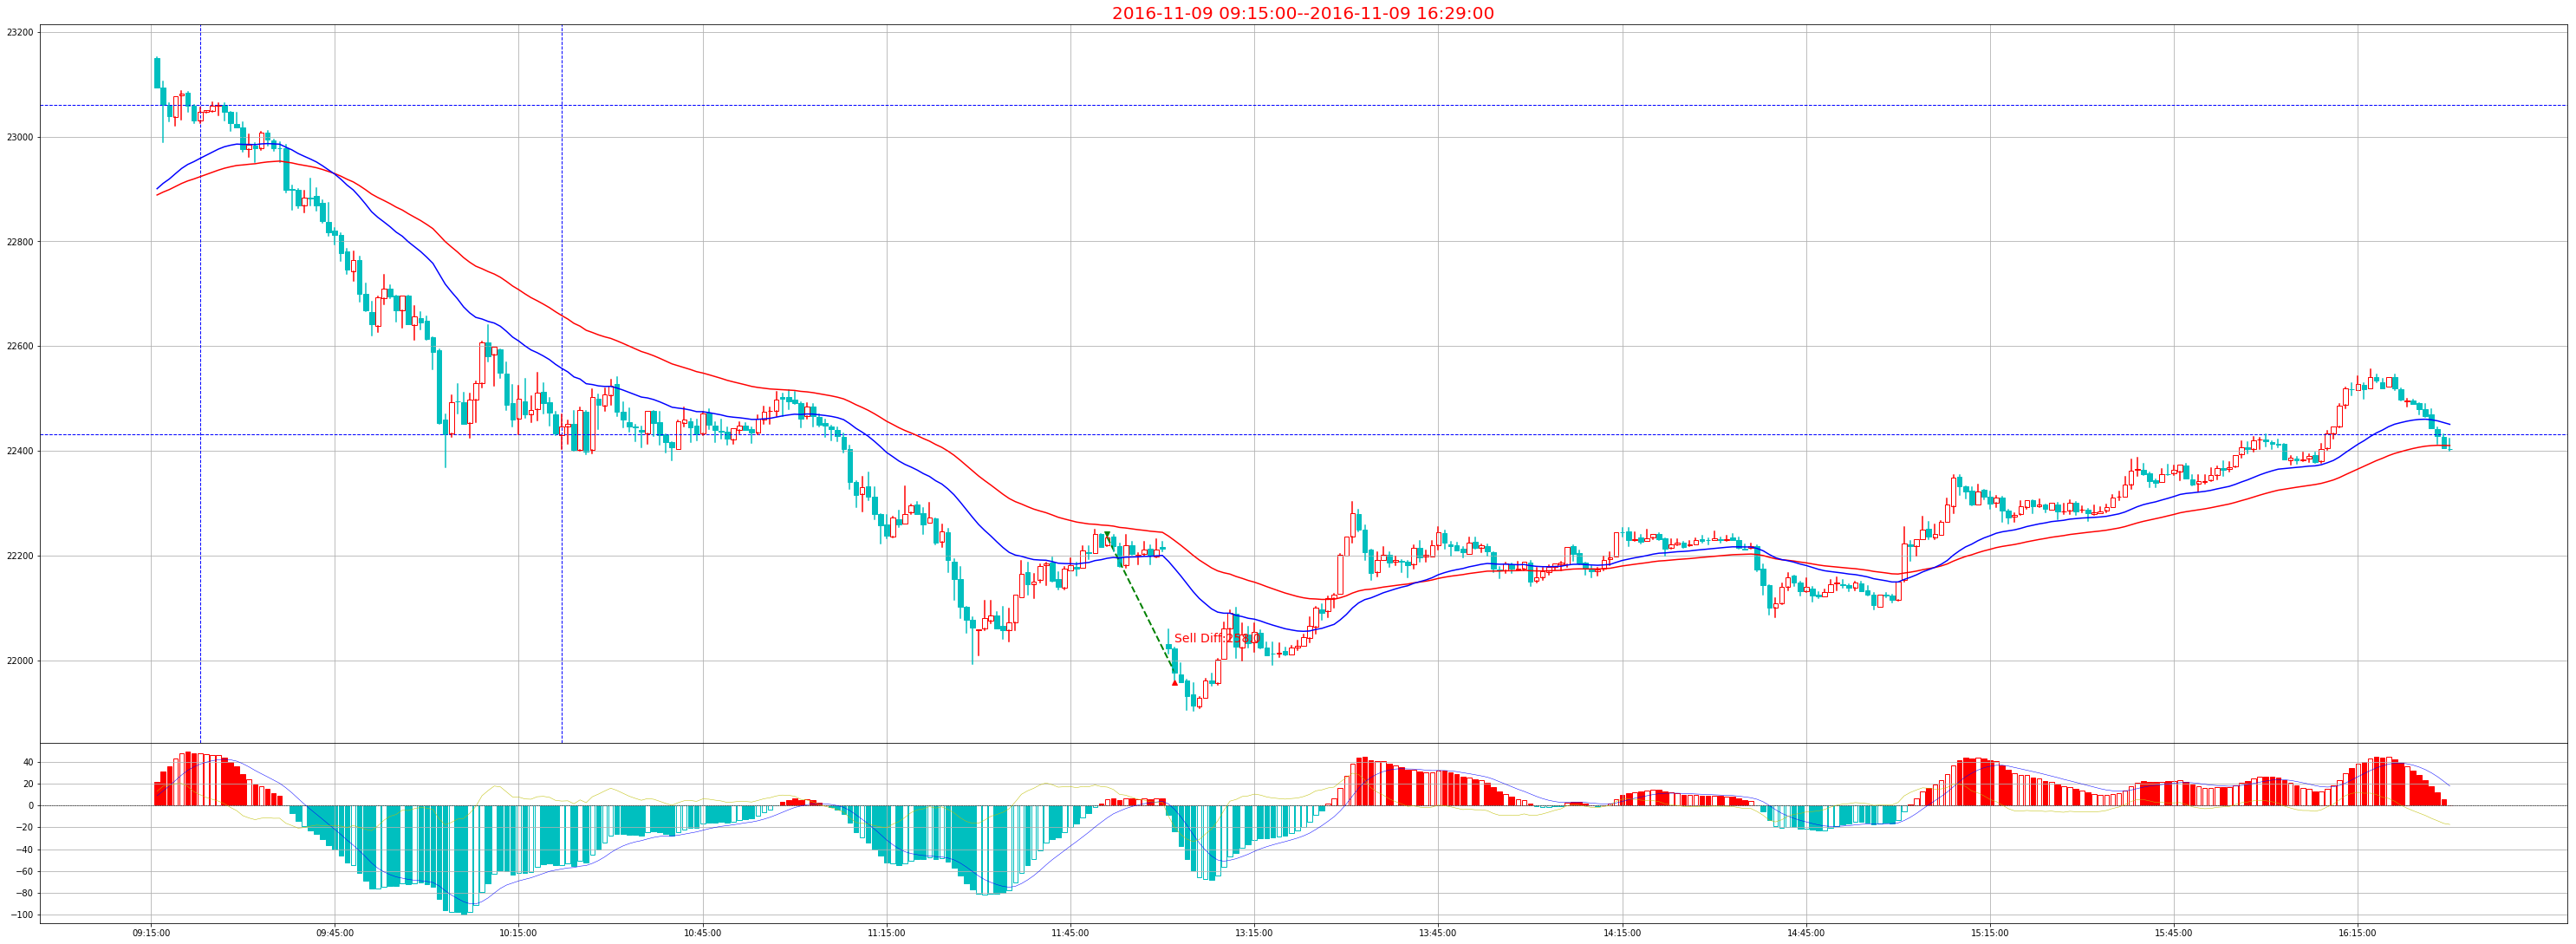

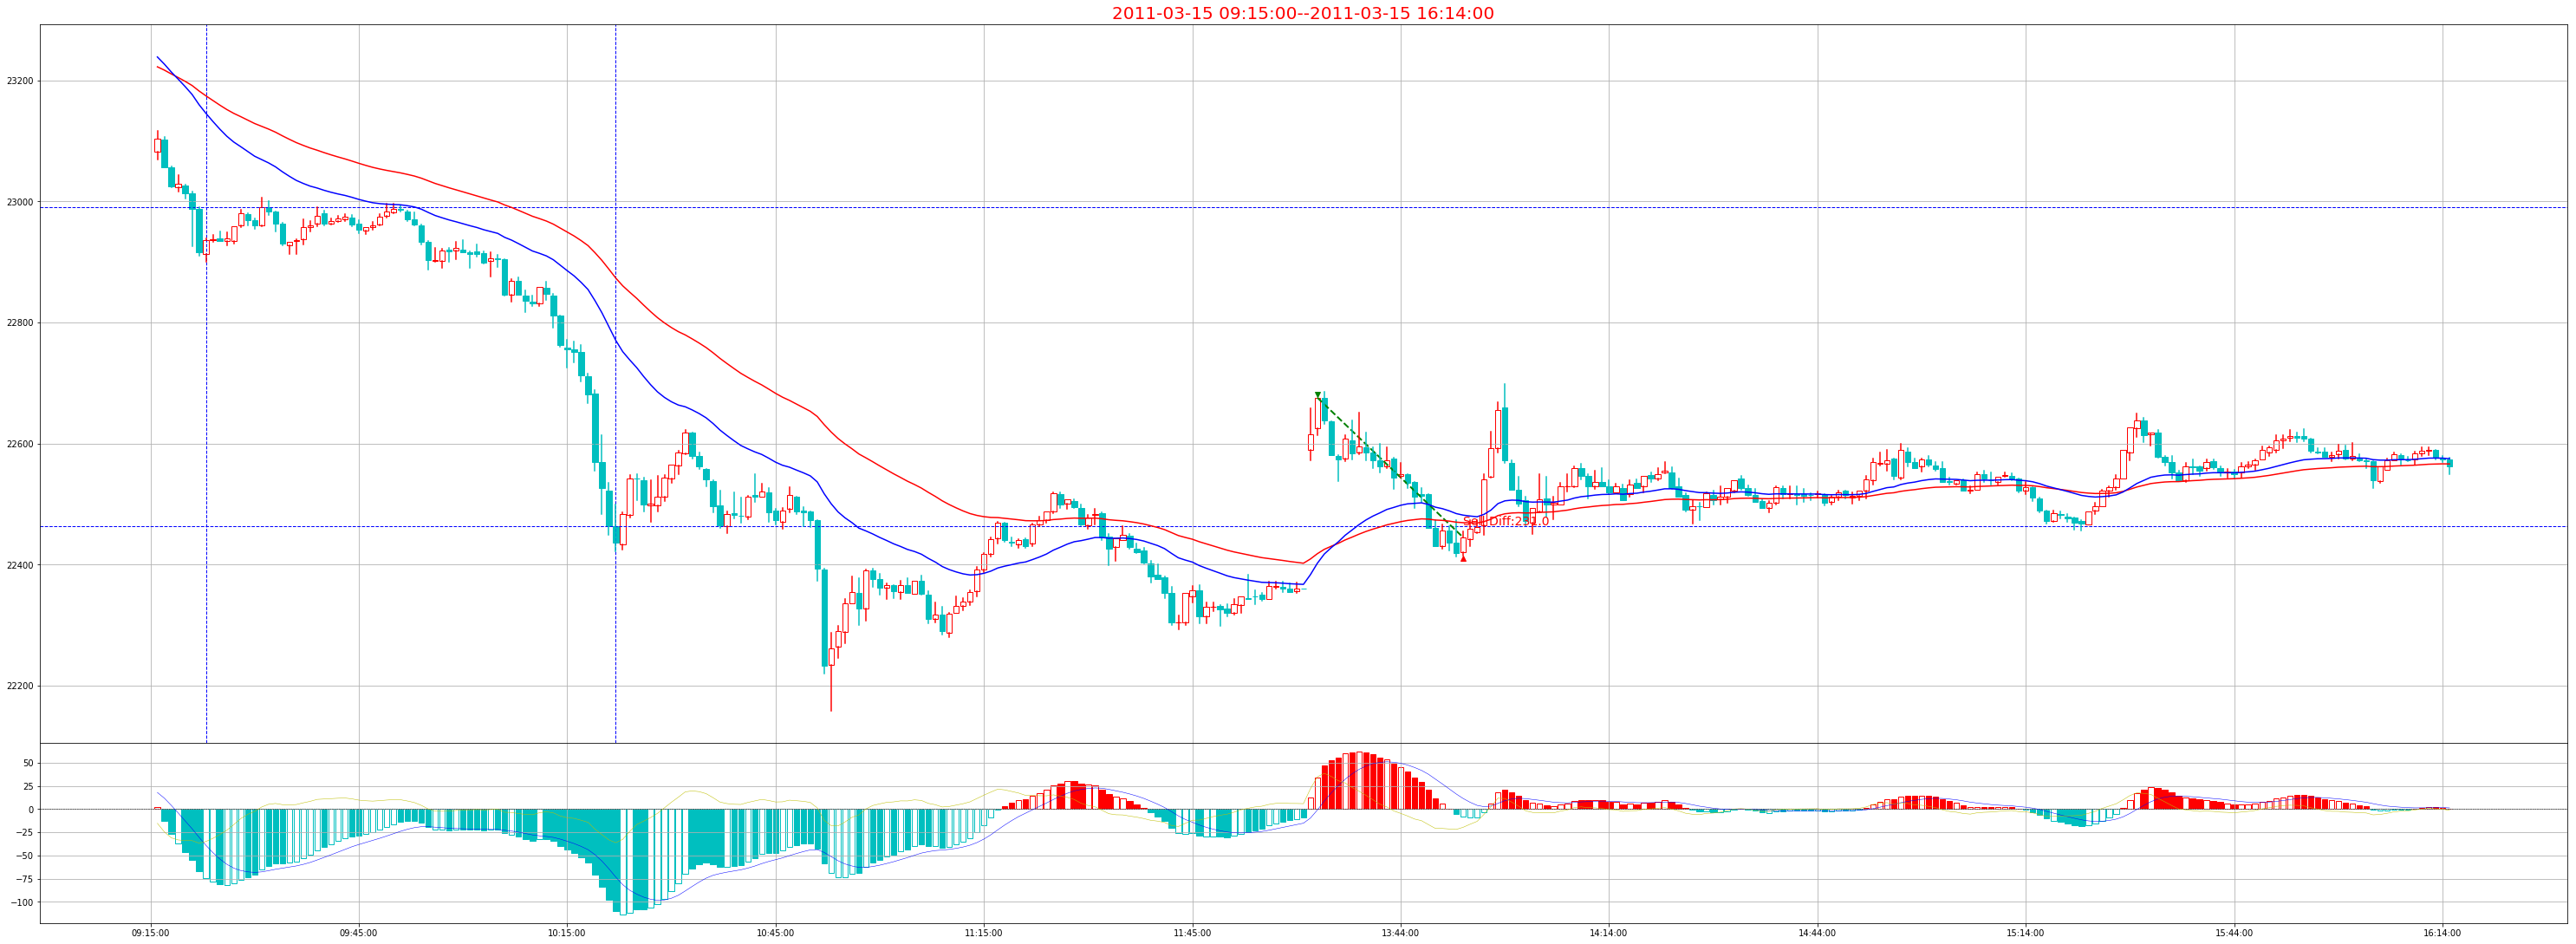

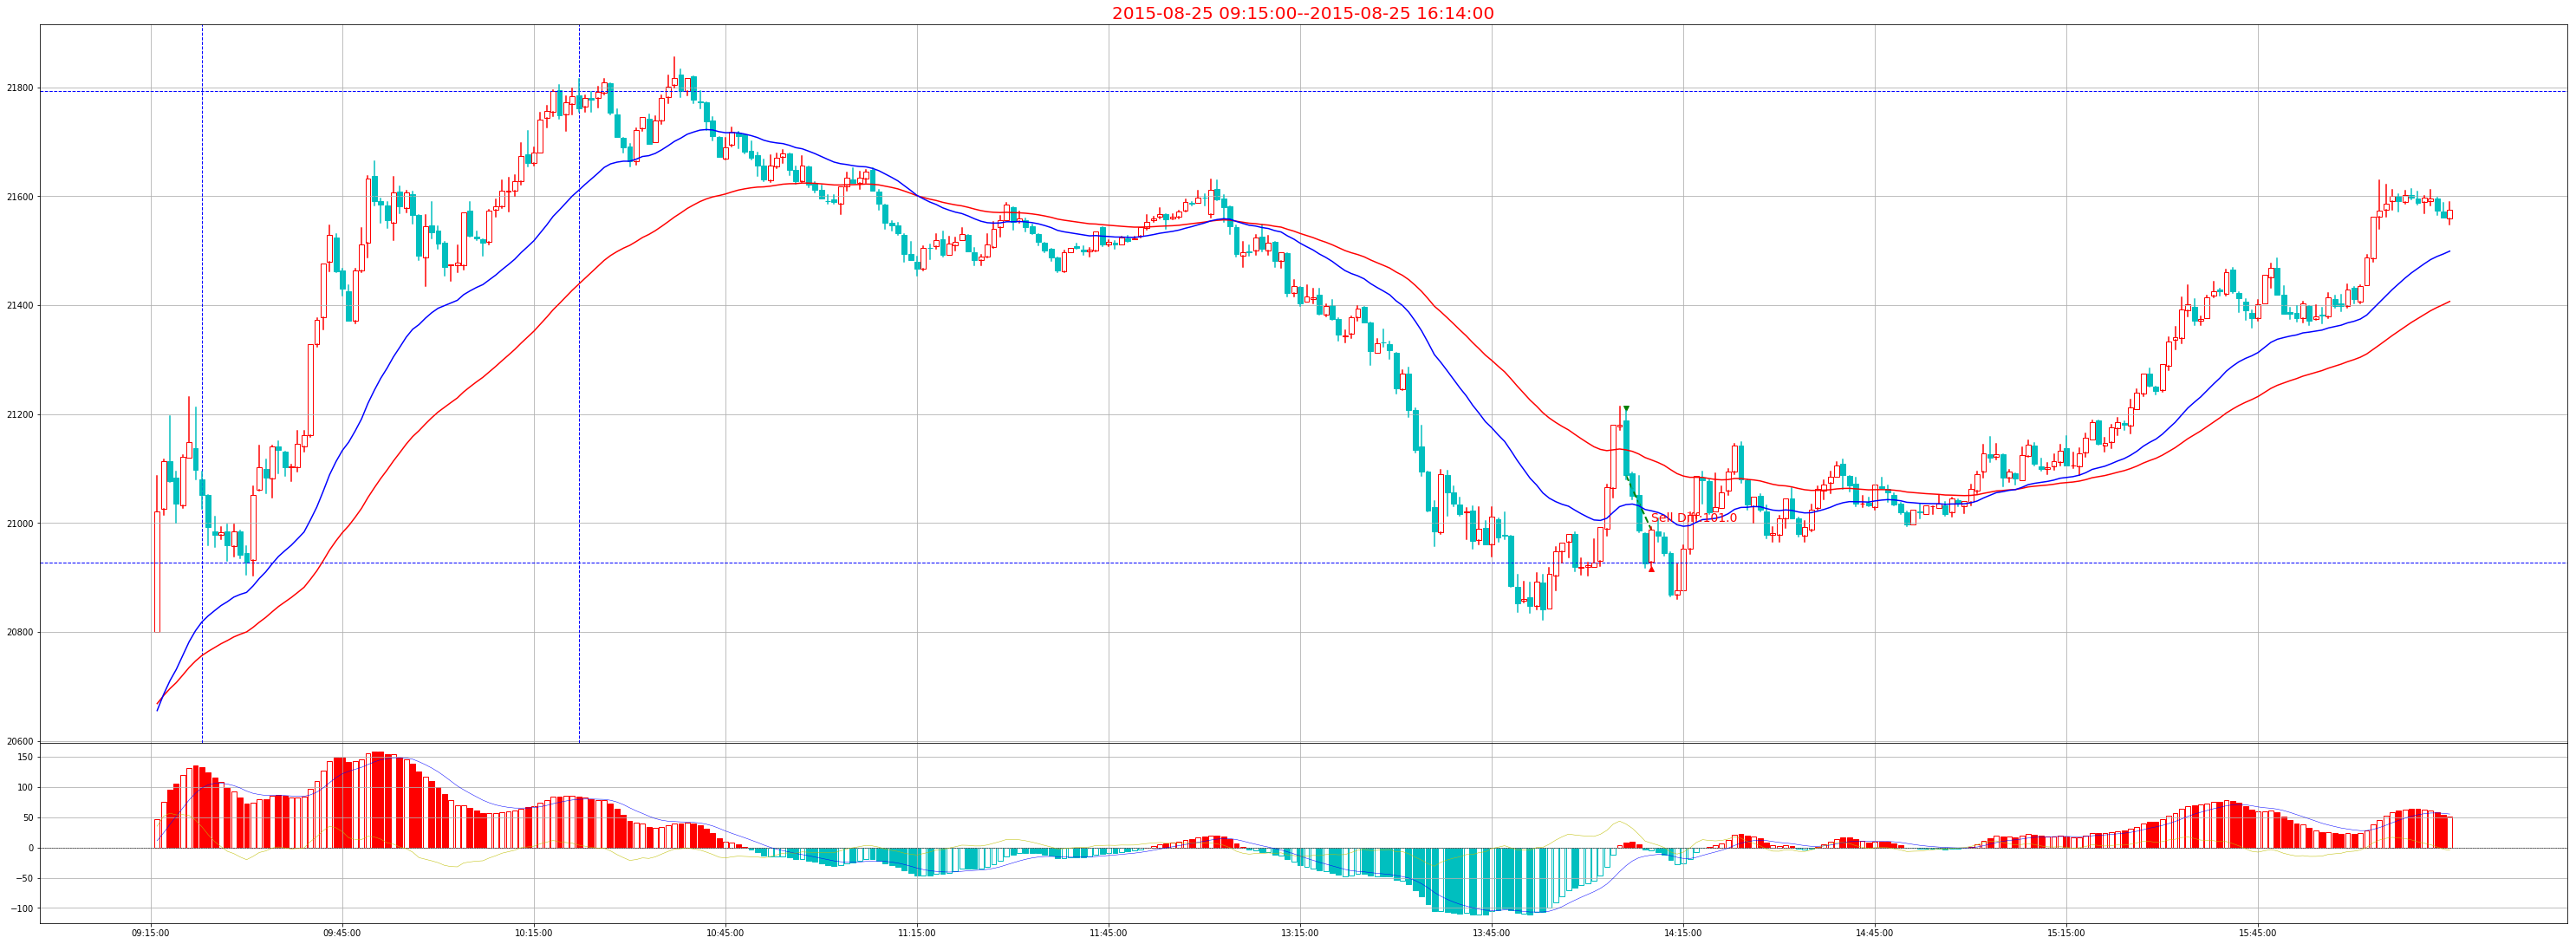

In [64]:
#图显
from kline import Kline
k=Kline()
# drawKK(k,'HSI1103','2011-02-28')
# cont=(macd.state=='red') &(macd.no==1) & (macd.ma60_state=='under')
df2=trade.sort_values('diff')
for i,row in df2.tail(5).iterrows():
#     print(row['prod'],row['date'])
    file="img/macd_h10_%s"%(row['date'].date())
    idx1=int(row['open_idx'])
    idx2=int(row['close_idx'])
    drawKK(k,row['prod'],row['date'],trade=[row['state'],idx1,idx2])

In [51]:
t1=trade.set_index('date').resample('B')['diff'].agg(Calc)
t1.rename(columns={'sum':'diff'},inplace=True) 
t1=t1[~np.isnan(t1['diff'])]
# Get_Drawdown(t1)
t1.head(30)

,diff,count,mean,std,max,min
date,,,,,,
2011-01-05,-102.0,1,-102.000000,NaN,-102.0,-102.0
2011-01-06,-53.0,1,-53.000000,NaN,-53.0,-53.0
2011-01-07,-4.0,2,-2.000000,31.112698,20.0,-24.0
2011-01-10,35.0,3,11.666667,3.214550,14.0,8.0
2011-01-11,25.0,1,25.000000,NaN,25.0,25.0
2011-01-12,-16.0,1,-16.000000,NaN,-16.0,-16.0
2011-01-13,-18.0,1,-18.000000,NaN,-18.0,-18.0
2011-01-14,-12.0,1,-12.000000,NaN,-12.0,-12.0
2011-01-17,13.0,4,3.250000,13.622897,17.0,-15.0


In [48]:
np.isnan?

In [31]:
import numpy as np
def Get_Drawdown(F1):
    res=[]
    rec={}
    maxDown={}
    All=[]
    maxDown['Dn_Len']=0
    maxDown['Dn_Lose']=0
    maxDown['Dn_Lose1']=0

    for i,row in F1.iterrows():
        idx=0
        if row['diff']>=0:
            rec={}
            if len(res)>0:
                rec['len']=len(res)
                rec['res']=sum(res)
                rec['begin']=i

                if rec['len']>maxDown['Dn_Len']:
                    maxDown['Dn_Len']=rec['len']
                    maxDown['Dn_Lose']=rec['res']
                    maxDown['Dn_Idx']=i
                    print(res)
                if rec['res']<maxDown['Dn_Lose1']:
                    maxDown['Dn_Lose1']=rec['res']
                    maxDown['Dn_Len1']=rec['len']
                    maxDown['Dn_Idx1']=i

            idx=0
            res=[]
        elif not np.isnan(row['diff']) :
            res.append(row['diff'])
    return maxDown

最大回撤开始:2011-09-22 00:00:00 最大回撤结束:2011-10-12 00:00:00 最大回撤:983.0
最长回撤持续开始:2017-03-24 00:00:00 最长回撤持续结束:2017-11-20 00:00:00 最长回撤时间: 241 days 00:00:00
MaxDrawdown: 983.0   MaxDrawdown_time: [Timestamp('2011-09-22 00:00:00'), Timestamp('2011-10-12 00:00:00')]


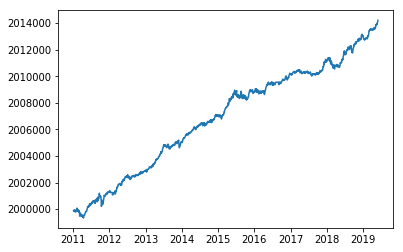

In [61]:
pnl_values = t1['diff']
portfolio_value = pnl_values.cumsum() + 2000000  # 设置一个很大的初始资金来防止计算回撤发生误差
xs = portfolio_value.values
#     rt = portfolio.unit_net_value.values
max_dd_end = np.argmax(np.maximum.accumulate(xs) / xs)
if max_dd_end == 0:
    max_dd_end = len(xs) - 1
max_dd_start = np.argmax(xs[:max_dd_end]) if max_dd_end > 0 else 0

# maxdrawdown duration
al_cum = np.maximum.accumulate(xs)
a = np.unique(al_cum, return_counts=True)
start_idx = np.argmax(a[1])
m = a[0][start_idx]
al_cum_array = np.where(al_cum == m)
max_ddd_start_day = al_cum_array[0][0]
max_ddd_end_day = al_cum_array[0][-1]

print(f'最大回撤开始:{portfolio_value.index[max_dd_start]} 最大回撤结束:{portfolio_value.index[max_dd_end]} 最大回撤:{portfolio_value[max_dd_start] - portfolio_value[max_dd_end]}')
print(f'最长回撤持续开始:{pnl_values.index[max_ddd_start_day]} 最长回撤持续结束:{pnl_values.index[max_ddd_end_day]} 最长回撤时间: {pnl_values.index[max_ddd_end_day] - pnl_values.index[max_ddd_start_day]}')

ax = plt.subplot()
ax.plot(portfolio_value)
#     ax.plot([max_dd_start, max_dd_start], [portfolio_value.min(), portfolio_value.max()])
total = 0
Max = 0
MaxDrawdown = 0
Max_time = None
for t, p in pnl_values.items():
    total += p
    if total > Max:
        Max = total
        Max_time = t

    if Max - total > MaxDrawdown:
        MaxDrawdown = Max - total
        MaxDrawdown_period = [Max_time, t]
print('MaxDrawdown:', MaxDrawdown, '  MaxDrawdown_time:', MaxDrawdown_period)
    

In [57]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


d:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


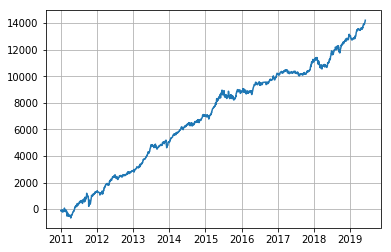

In [59]:
plt.plot(t1['diff'].cumsum())
plt.grid(True)